# Note
This script use another approach to cluster the STAS labels. We first use the trained **auto-encoder** to extract the feature vector of each image. Then, we use **HDBSCAN** to cluster the labels.

In [1]:
# Mount colab to our drive
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/2022_趨勢_機器學習比賽/')

Mounted at /content/drive/


# Package introduction

In [ ]:
# For data preprocessing
from keras.preprocessing.image import load_img, img_to_array

# For auto-encoder
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.utils.vis_utils import plot_model

# For clustering
!pip install hdbscan
import hdbscan
from sklearn.cluster import KMeans        # For testing
from sklearn.decomposition import PCA     # For testing

# Others
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# Read the list of our data sets

In [ ]:
img_path = 'OBJ_Train_Datasets/Train_Images_STAS_only/'
STAS=[]

# creates a ScandirIterator aliased as files
with os.scandir(img_path) as files:
  # loops through each file in the directory
  for file in files:
    if file.name.endswith('.jpg'):
      # adds only the image files to the flowers list
      STAS.append(file.name)
print(STAS)

# Divide our data into training set and validation set
random.Random(0).shuffle(STAS)
val_set = STAS[:int(len(STAS)/10.)]
tr_set = STAS[int(len(STAS)/10.):];

# Read the data and the preprocessing


In [24]:
def preprocessing(img_name,img_path):
  image = load_img(img_path+img_name,target_size=(128,128))   # The target size (height, width) redshape the input. (but how?)
  image = img_to_array(image)
  image = image/255.     #minmax_normalized
  return image

In [ ]:
# Read the training set.
count=0
tr_img_data=[]
for img_name in tr_set:
  print(count)
  count+=1
  tr_img = preprocessing(img_name,img_path)
  tr_img_data.append(tr_img)
tr_img_data = np.array(tr_img_data)

# Read the val set.
val_img_data=[]
for img_name in val_set:
  val_img = preprocessing(img_name,img_path)
  val_img_data.append(val_img)
val_img_data = np.array(val_img_data)

# Build the auto-encoder model

In [ ]:
# The dimension of the embedding
# encoding_dim = 2
# Build the model
model = Sequential()
# encoder network
model.add(Conv2D(30,3,activation='relu',padding='same',input_shape=(128,128,3))) # input_shape: (batch_size,x,y,chan_num) or just (x,y,chan_num)
model.add(MaxPooling2D(2, padding = 'same'))  # ref about padding in MaxPooling: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
model.add(Conv2D(15,3,activation='relu',padding='same'))
model.add(MaxPooling2D(2, padding = 'same'))
# decoder network
model.add(Conv2D(15,3,activation='relu',padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(30,3,activation='relu',padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(3,3,activation='sigmoid', padding= 'same')) # output layer
model.compile(optimizer='adam', loss ='MeanAbsoluteError')
# plot_model(model)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 128, 128, 30)      840       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 15)        4065      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 15)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 15)        2040      
                                                                 
 up_sampling2d_11 (UpSamplin  (None, 64, 64, 15)      

# Start to training!

In [ ]:
model.fit(tr_img_data,tr_img_data,epochs=50,batch_size=128,validation_data=(val_img_data,val_img_data))

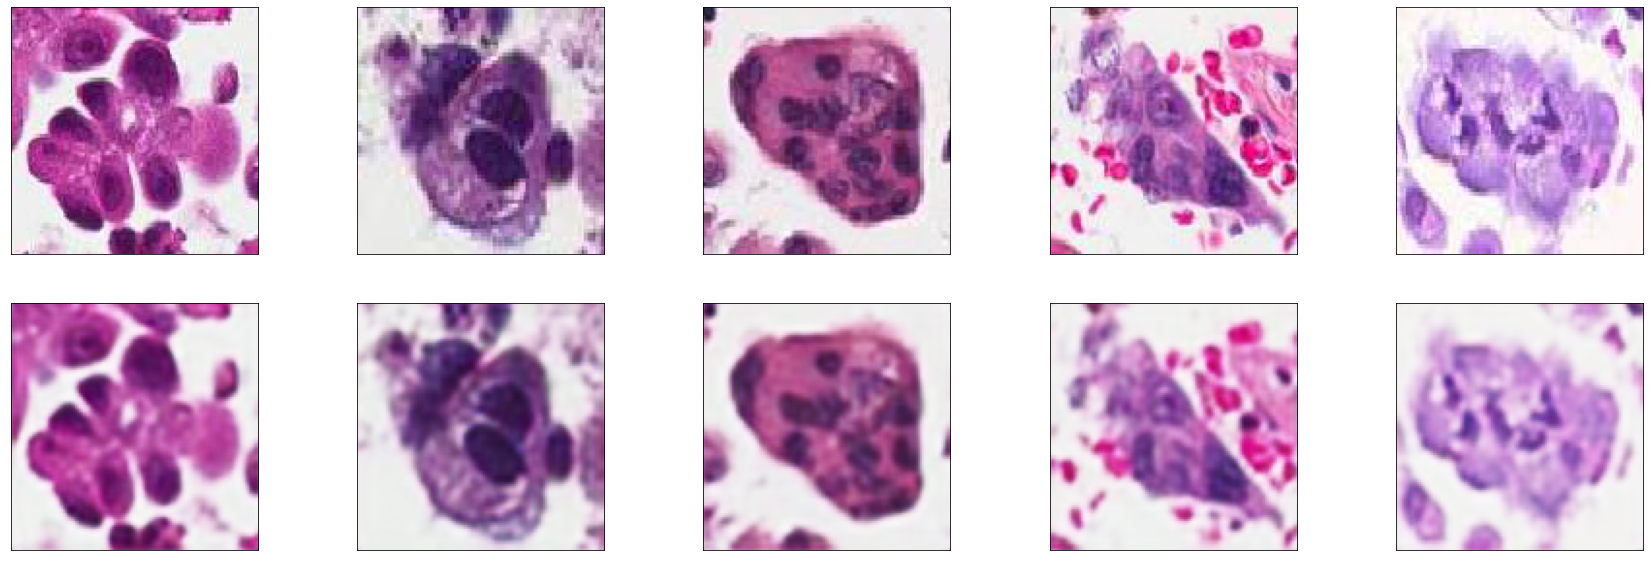

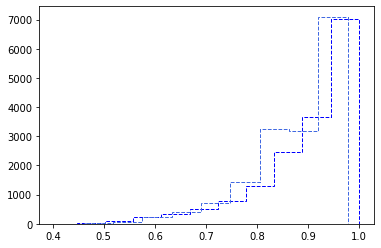

In [ ]:
# Check the fitting result and save the images
output_path = 'OBJ_Train_Datasets/autoencoder_output/'
pred = model.predict(val_img_data)
plt.figure(figsize=(30, 10))
for i in range(5):
    
    # Display original
    val_img_recons = ((val_img_data[i]))
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(val_img_data[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    val_img_pre_recons = ((pred[i]))
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Save the figures

plt.show();
# plt.hist(val_img_data[i][:,:,0].flatten(),linestyle='dashed',histtype='step',color='red');
# plt.hist(val_img_data[i][:,:,1].flatten(),linestyle='dashed',histtype='step',color='g');
plt.hist(val_img_data[i][:,:,2].flatten(),linestyle='dashed',histtype='step',color='b');
# plt.hist(pred[i][:,:,0].flatten(),linestyle='dashed',histtype='step',color='firebrick');
# plt.hist(pred[i][:,:,1].flatten(),linestyle='dashed',histtype='step',color='springgreen');
plt.hist(pred[i][:,:,2].flatten(),linestyle='dashed',histtype='step',color='royalblue');
# val_img_data[i].shape